In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
cnt_handler = trainer.CntTrainHandler()
profile_handler = trainer.AmtProfileHandler()
rank_handler = trainer.RankTopHandler()

In [3]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
cnt_feats = loader.load_result('2021_12_15_cnt_feats.joblib')

In [4]:
cnt_handler.update_data(cnt_feats)
cnt_handler.train = cnt_handler.train.reset_index(drop=True)
cnt_handler.test = cnt_handler.test.reset_index(drop=True)
cnt_handler.y = cnt_handler.y.reset_index(drop=True)


Start Update Data
Start Processing y label
Start Processing train set
Start Processing test set
Finished updating data


In [5]:
cnt_test = cnt_handler.test.copy()
cnt_test['dt'] = 25

cnt_train = cnt_handler.train.copy()
cnt_train['dt'] = [23] * 500000 + [24] * 500000

ylabels = cnt_handler.y.copy()

In [6]:
cnt_train = cnt_train.reset_index(drop=True)
cnt_test = cnt_test.reset_index(drop=True)

profile_handler.update_data(profile_feats)
cnt_train = pd.merge(cnt_train, profile_feats, on=['chid', 'dt'], how='left')
cnt_test = pd.merge(cnt_test, profile_feats, on=['chid', 'dt'], how='left')

cnt_train = cnt_train.drop(['chid', 'dt'], axis=1)
cnt_test = cnt_test.drop(['chid', 'dt'], axis=1)

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [7]:
# profile_handler.update_data(pd.concat([amt_train ,amt_test]).copy())
cnt_train = profile_handler.transform(cnt_train)
cnt_test = profile_handler.transform(cnt_test)

In [8]:
# drop 1~18 non imp amt and cnt
non_imp_cates = l3 = [
    x for x in cnt_handler.shop_cate if x not in cnt_handler.ylabels
]
drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        cnt_cate_col = "shop_{}_cnt_{}".format(non_imp_cate, dt - 24)
        drop_feats.append(cnt_cate_col)
cnt_train = cnt_train.drop(drop_feats, axis=1)
cnt_test = cnt_test.drop(drop_feats, axis=1)

In [9]:
# rank feats
rank_feats = loader.load_result('2021_12_17_rank_feats.joblib')
rank_handler.update_data(rank_feats)
rank_train = rank_handler.train.drop(['chid'], axis=1)
rank_test = rank_handler.test.drop(['chid'], axis=1)
rank_train = rank_train.reset_index(drop=True)
rank_test = rank_test.reset_index(drop=True)

Start Update Data
Start Processing train set
Start Processing test set
Finished updating data


In [10]:
cnt_train = pd.concat([cnt_train,rank_train], axis=1)
cnt_test = pd.concat([cnt_test, rank_test], axis=1)

In [11]:
X = cnt_train.copy()
y = ylabels.reset_index(drop=True).copy()

In [12]:
amt_results = loader.load_result('2021_12_20_amt_train_results.joblib')

In [13]:
idx_results = amt_results[2]

In [14]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    # 'min_sum_hessian_in_leaf': 16,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [15]:
profile_handler.cate_feats = profile_handler.cate_feats + [
    "how_many_cate_{}".format(dt - 24) for dt in range(2, 24)
] + ['how_many_cate_imp_{}'.format(dt - 24) for dt in range(2, 24)]

target_cols = ["top1_{}".format(dt - 24) for dt in range(2, 24)] + [
    "top2_{}".format(dt - 24) for dt in range(2, 24)
] + ['top3_{}'.format(dt - 24) for dt in range(2, 24)]
target_cols = target_cols + [
    "imp_top1_{}".format(dt - 24) for dt in range(2, 24)
] + ["imp_top2_{}".format(dt - 24) for dt in range(2, 24)
     ] + ["imp_top3_{}".format(dt - 24) for dt in range(2, 24)]

profile_handler.cate_feats = profile_handler.cate_feats + target_cols

# te = trainer.TargetEncoder(target_cols)

In [16]:
def get_int_trans(x):
    if x == 'other':
        return 49
    elif x == '-1':
        return 50
    else:
        return int(x)


for col in target_cols:
    X[col] = X[col].apply(get_int_trans)
    cnt_test[col] = cnt_test[col].apply(get_int_trans)

Training fold 2


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.866332	valid_1's auc: 0.854912
[100]	training's auc: 0.871088	valid_1's auc: 0.85621
[150]	training's auc: 0.875803	valid_1's auc: 0.856915
[200]	training's auc: 0.880617	valid_1's auc: 0.857376
[250]	training's auc: 0.885576	valid_1's auc: 0.857677
[300]	training's auc: 0.890909	valid_1's auc: 0.857932
[350]	training's auc: 0.89627	valid_1's auc: 0.85816
[400]	training's auc: 0.901688	valid_1's auc: 0.858359
[450]	training's auc: 0.906995	valid_1's auc: 0.858514
[500]	training's auc: 0.912154	valid_1's auc: 0.858642
[550]	training's auc: 0.916962	valid_1's auc: 0.858734
[600]	training's auc: 0.921559	valid_1's auc: 0.8588
[650]	training's auc: 0.925888	valid_1's auc: 0.858818
[700]	training's auc: 0.929913	valid_1's auc: 0.858869
[750]	training's auc: 0.933781	valid_1's auc: 0.858889
[800]	training's auc: 0.937434	valid_1's auc: 0.858899
[850]	training's auc: 0.940848	valid_1's auc: 0.858862
Early sto

<Figure size 864x432 with 0 Axes>

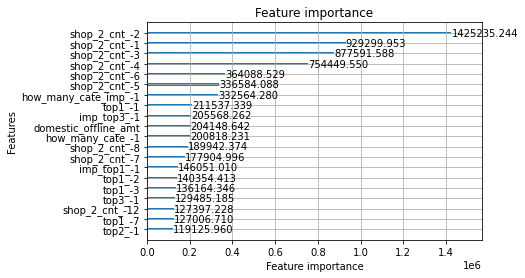

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.913601	valid_1's auc: 0.893706
[100]	training's auc: 0.920132	valid_1's auc: 0.894932
[150]	training's auc: 0.927038	valid_1's auc: 0.895265
[200]	training's auc: 0.934524	valid_1's auc: 0.895646
[250]	training's auc: 0.942147	valid_1's auc: 0.895833
[300]	training's auc: 0.949518	valid_1's auc: 0.896092
[350]	training's auc: 0.95649	valid_1's auc: 0.89624
[400]	training's auc: 0.962554	valid_1's auc: 0.896383
[450]	training's auc: 0.967849	valid_1's auc: 0.896431
[500]	training's auc: 0.972319	valid_1's auc: 0.896357
[550]	training's auc: 0.976054	valid_1's auc: 0.896313
Early stopping, best iteration is:
[450]	training's auc: 0.967849	valid_1's auc: 0.896431


<Figure size 864x432 with 0 Axes>

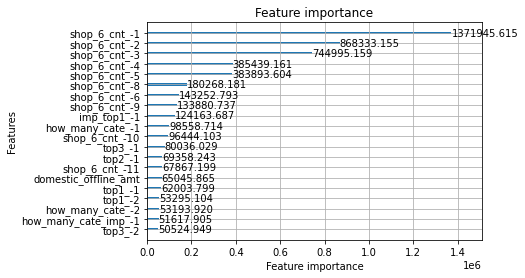

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.925906	valid_1's auc: 0.920117
[100]	training's auc: 0.92848	valid_1's auc: 0.92114
[150]	training's auc: 0.930815	valid_1's auc: 0.921687
[200]	training's auc: 0.93336	valid_1's auc: 0.922216
[250]	training's auc: 0.936137	valid_1's auc: 0.922616
[300]	training's auc: 0.939062	valid_1's auc: 0.922882
[350]	training's auc: 0.942122	valid_1's auc: 0.923054
[400]	training's auc: 0.94533	valid_1's auc: 0.923233
[450]	training's auc: 0.948604	valid_1's auc: 0.923387
[500]	training's auc: 0.951918	valid_1's auc: 0.923518
[550]	training's auc: 0.9551	valid_1's auc: 0.923679
[600]	training's auc: 0.958153	valid_1's auc: 0.923773
[650]	training's auc: 0.960883	valid_1's auc: 0.923857
[700]	training's auc: 0.963565	valid_1's auc: 0.923926
[750]	training's auc: 0.966154	valid_1's auc: 0.923974
[800]	training's auc: 0.968527	valid_1's auc: 0.923996
[850]	training's auc: 0.970707	valid_1's auc: 0.924021
[900]	trai

<Figure size 864x432 with 0 Axes>

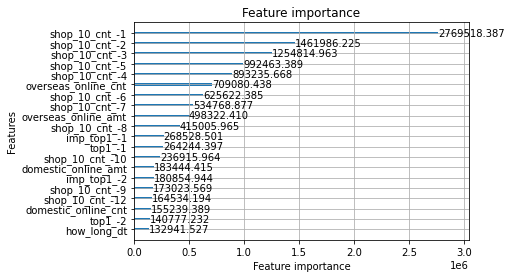

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.923734	valid_1's auc: 0.912752
[100]	training's auc: 0.927233	valid_1's auc: 0.913796
[150]	training's auc: 0.930953	valid_1's auc: 0.91435
[200]	training's auc: 0.934828	valid_1's auc: 0.914709
[250]	training's auc: 0.939027	valid_1's auc: 0.915148
[300]	training's auc: 0.943666	valid_1's auc: 0.915412
[350]	training's auc: 0.948383	valid_1's auc: 0.915584
[400]	training's auc: 0.953077	valid_1's auc: 0.915789
[450]	training's auc: 0.957548	valid_1's auc: 0.915939
[500]	training's auc: 0.961658	valid_1's auc: 0.916014
[550]	training's auc: 0.965427	valid_1's auc: 0.916111
[600]	training's auc: 0.968749	valid_1's auc: 0.916173
[650]	training's auc: 0.971754	valid_1's auc: 0.916193
[700]	training's auc: 0.974374	valid_1's auc: 0.916196
Early stopping, best iteration is:
[633]	training's auc: 0.970752	valid_1's auc: 0.916213


<Figure size 864x432 with 0 Axes>

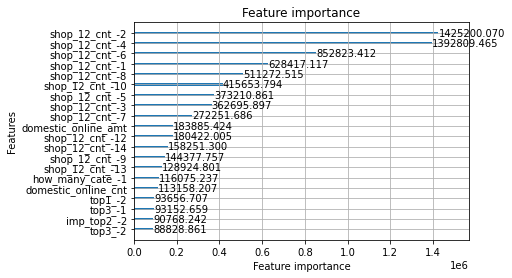

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.9576	valid_1's auc: 0.951533
[100]	training's auc: 0.960293	valid_1's auc: 0.952922
[150]	training's auc: 0.962439	valid_1's auc: 0.953459
[200]	training's auc: 0.964684	valid_1's auc: 0.953915
[250]	training's auc: 0.967313	valid_1's auc: 0.954453
[300]	training's auc: 0.970111	valid_1's auc: 0.954839
[350]	training's auc: 0.972999	valid_1's auc: 0.955207
[400]	training's auc: 0.975999	valid_1's auc: 0.955572
[450]	training's auc: 0.978828	valid_1's auc: 0.95587
[500]	training's auc: 0.981409	valid_1's auc: 0.956154
[550]	training's auc: 0.983791	valid_1's auc: 0.956326
[600]	training's auc: 0.985869	valid_1's auc: 0.956471
[650]	training's auc: 0.98767	valid_1's auc: 0.95659
[700]	training's auc: 0.989279	valid_1's auc: 0.956724
[750]	training's auc: 0.99073	valid_1's auc: 0.956784
[800]	training's auc: 0.991986	valid_1's auc: 0.956823
[850]	training's auc: 0.993066	valid_1's auc: 0.956832
[900]	trai

<Figure size 864x432 with 0 Axes>

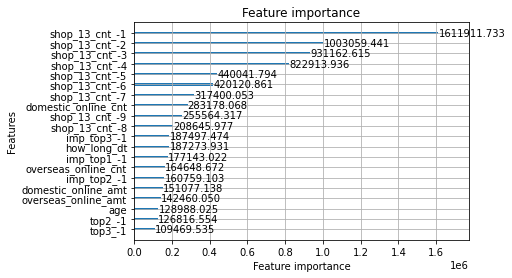

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.882658	valid_1's auc: 0.872837
[100]	training's auc: 0.885889	valid_1's auc: 0.873521
[150]	training's auc: 0.889484	valid_1's auc: 0.874325
[200]	training's auc: 0.893269	valid_1's auc: 0.874923
[250]	training's auc: 0.897199	valid_1's auc: 0.875375
[300]	training's auc: 0.901256	valid_1's auc: 0.875741
[350]	training's auc: 0.905417	valid_1's auc: 0.876054
[400]	training's auc: 0.909541	valid_1's auc: 0.876255
[450]	training's auc: 0.913715	valid_1's auc: 0.876394
[500]	training's auc: 0.917532	valid_1's auc: 0.876497
[550]	training's auc: 0.921279	valid_1's auc: 0.876616
[600]	training's auc: 0.924826	valid_1's auc: 0.876697
[650]	training's auc: 0.928169	valid_1's auc: 0.87676
[700]	training's auc: 0.931299	valid_1's auc: 0.876809
[750]	training's auc: 0.93435	valid_1's auc: 0.876843
[800]	training's auc: 0.937184	valid_1's auc: 0.876858
[850]	training's auc: 0.939939	valid_1's auc: 0.87688
[900]	t

<Figure size 864x432 with 0 Axes>

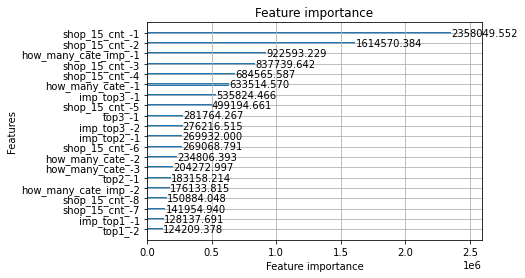

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.875974	valid_1's auc: 0.852029
[100]	training's auc: 0.884418	valid_1's auc: 0.853298
[150]	training's auc: 0.892744	valid_1's auc: 0.854336
[200]	training's auc: 0.901092	valid_1's auc: 0.854696
[250]	training's auc: 0.909616	valid_1's auc: 0.854974
[300]	training's auc: 0.918157	valid_1's auc: 0.855132
[350]	training's auc: 0.926407	valid_1's auc: 0.855332
[400]	training's auc: 0.934254	valid_1's auc: 0.855424
[450]	training's auc: 0.941487	valid_1's auc: 0.855446
[500]	training's auc: 0.948053	valid_1's auc: 0.85548
[550]	training's auc: 0.953945	valid_1's auc: 0.855452
[600]	training's auc: 0.959226	valid_1's auc: 0.85543
Early stopping, best iteration is:
[503]	training's auc: 0.94841	valid_1's auc: 0.855487


<Figure size 864x432 with 0 Axes>

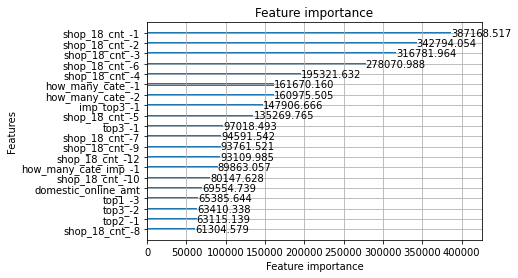

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.840969	valid_1's auc: 0.811969
[100]	training's auc: 0.851289	valid_1's auc: 0.81366
[150]	training's auc: 0.860666	valid_1's auc: 0.814832
[200]	training's auc: 0.869789	valid_1's auc: 0.815766
[250]	training's auc: 0.878996	valid_1's auc: 0.816497
[300]	training's auc: 0.888143	valid_1's auc: 0.817037
[350]	training's auc: 0.89693	valid_1's auc: 0.817398
[400]	training's auc: 0.9056	valid_1's auc: 0.817715
[450]	training's auc: 0.913806	valid_1's auc: 0.817868
[500]	training's auc: 0.921487	valid_1's auc: 0.817919
[550]	training's auc: 0.928054	valid_1's auc: 0.817959
[600]	training's auc: 0.934559	valid_1's auc: 0.817994
[650]	training's auc: 0.940315	valid_1's auc: 0.817954
Early stopping, best iteration is:
[586]	training's auc: 0.932794	valid_1's auc: 0.818015


<Figure size 864x432 with 0 Axes>

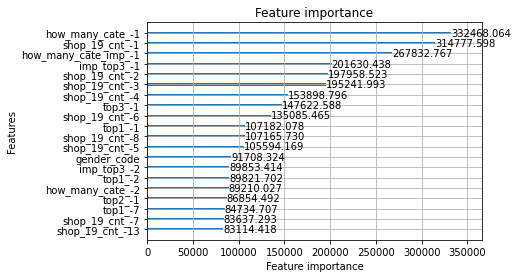

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.851443	valid_1's auc: 0.820485
[100]	training's auc: 0.862913	valid_1's auc: 0.822261
[150]	training's auc: 0.873909	valid_1's auc: 0.823214
[200]	training's auc: 0.884754	valid_1's auc: 0.82391
[250]	training's auc: 0.895584	valid_1's auc: 0.82447
[300]	training's auc: 0.90607	valid_1's auc: 0.82489
[350]	training's auc: 0.915925	valid_1's auc: 0.82521
[400]	training's auc: 0.924733	valid_1's auc: 0.825513
[450]	training's auc: 0.932852	valid_1's auc: 0.825663
[500]	training's auc: 0.939991	valid_1's auc: 0.825787
[550]	training's auc: 0.946419	valid_1's auc: 0.825816
[600]	training's auc: 0.951916	valid_1's auc: 0.825758
Early stopping, best iteration is:
[546]	training's auc: 0.945963	valid_1's auc: 0.825827


<Figure size 864x432 with 0 Axes>

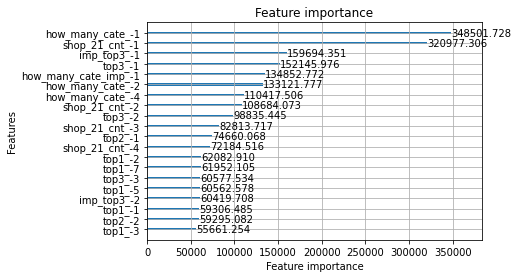

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.894958	valid_1's auc: 0.874612
[100]	training's auc: 0.901174	valid_1's auc: 0.875374
[150]	training's auc: 0.908047	valid_1's auc: 0.875814
[200]	training's auc: 0.914966	valid_1's auc: 0.876371
[250]	training's auc: 0.922477	valid_1's auc: 0.876741
[300]	training's auc: 0.929736	valid_1's auc: 0.877128
[350]	training's auc: 0.936963	valid_1's auc: 0.87738
[400]	training's auc: 0.943746	valid_1's auc: 0.877619
[450]	training's auc: 0.950101	valid_1's auc: 0.877737
[500]	training's auc: 0.955788	valid_1's auc: 0.877788
[550]	training's auc: 0.961127	valid_1's auc: 0.877762
[600]	training's auc: 0.965621	valid_1's auc: 0.877747
Early stopping, best iteration is:
[509]	training's auc: 0.956759	valid_1's auc: 0.877798


<Figure size 864x432 with 0 Axes>

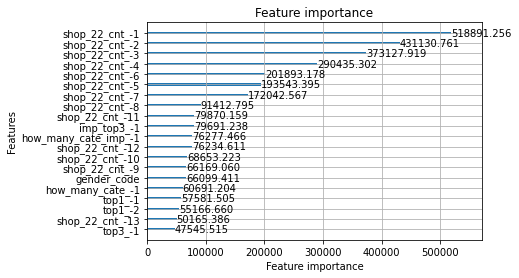

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.88166	valid_1's auc: 0.862369
[100]	training's auc: 0.888907	valid_1's auc: 0.863796
[150]	training's auc: 0.895792	valid_1's auc: 0.864553
[200]	training's auc: 0.902912	valid_1's auc: 0.865169
[250]	training's auc: 0.910161	valid_1's auc: 0.865566
[300]	training's auc: 0.917604	valid_1's auc: 0.865917
[350]	training's auc: 0.924992	valid_1's auc: 0.866192
[400]	training's auc: 0.932296	valid_1's auc: 0.866309
[450]	training's auc: 0.939119	valid_1's auc: 0.866381
[500]	training's auc: 0.945335	valid_1's auc: 0.866457
[550]	training's auc: 0.95104	valid_1's auc: 0.866458
[600]	training's auc: 0.956101	valid_1's auc: 0.86647
Early stopping, best iteration is:
[527]	training's auc: 0.948523	valid_1's auc: 0.866493


<Figure size 864x432 with 0 Axes>

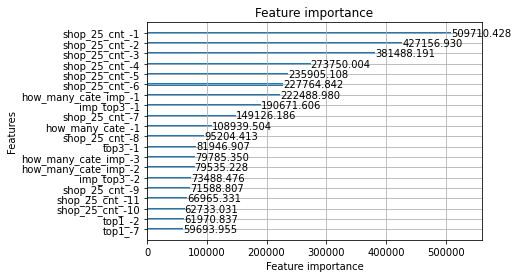

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.897174	valid_1's auc: 0.871825
[100]	training's auc: 0.90497	valid_1's auc: 0.8729
[150]	training's auc: 0.913309	valid_1's auc: 0.873325
[200]	training's auc: 0.921847	valid_1's auc: 0.873847
[250]	training's auc: 0.930625	valid_1's auc: 0.874232
[300]	training's auc: 0.939733	valid_1's auc: 0.874459
[350]	training's auc: 0.947911	valid_1's auc: 0.87466
[400]	training's auc: 0.955616	valid_1's auc: 0.874747
[450]	training's auc: 0.962308	valid_1's auc: 0.874745
[500]	training's auc: 0.968077	valid_1's auc: 0.874732
[550]	training's auc: 0.972854	valid_1's auc: 0.874708
Early stopping, best iteration is:
[466]	training's auc: 0.964264	valid_1's auc: 0.874782


<Figure size 864x432 with 0 Axes>

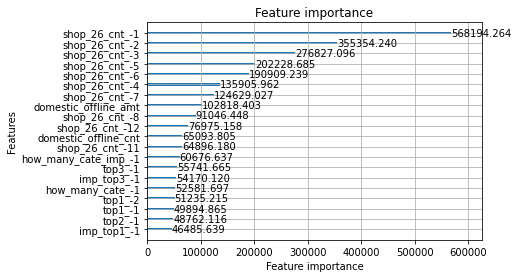

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942632	valid_1's auc: 0.939334
[100]	training's auc: 0.943981	valid_1's auc: 0.939779
[150]	training's auc: 0.945526	valid_1's auc: 0.940294
[200]	training's auc: 0.947084	valid_1's auc: 0.940506
[250]	training's auc: 0.948869	valid_1's auc: 0.940793
[300]	training's auc: 0.950854	valid_1's auc: 0.941025
[350]	training's auc: 0.95305	valid_1's auc: 0.941175
[400]	training's auc: 0.955345	valid_1's auc: 0.941268
[450]	training's auc: 0.957656	valid_1's auc: 0.941389
[500]	training's auc: 0.96005	valid_1's auc: 0.941456
[550]	training's auc: 0.962321	valid_1's auc: 0.941504
[600]	training's auc: 0.964397	valid_1's auc: 0.941541
[650]	training's auc: 0.966367	valid_1's auc: 0.941592
[700]	training's auc: 0.968223	valid_1's auc: 0.941608
[750]	training's auc: 0.970022	valid_1's auc: 0.941615
[800]	training's auc: 0.971652	valid_1's auc: 0.941616
[850]	training's auc: 0.973271	valid_1's auc: 0.941619
[900]	

<Figure size 864x432 with 0 Axes>

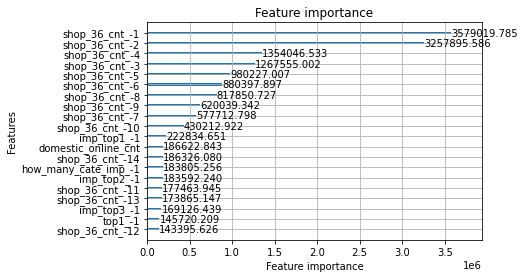

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.883425	valid_1's auc: 0.875571
[100]	training's auc: 0.886135	valid_1's auc: 0.876367
[150]	training's auc: 0.888984	valid_1's auc: 0.876951
[200]	training's auc: 0.892036	valid_1's auc: 0.87727
[250]	training's auc: 0.895352	valid_1's auc: 0.87761
[300]	training's auc: 0.898853	valid_1's auc: 0.877914
[350]	training's auc: 0.902417	valid_1's auc: 0.87819
[400]	training's auc: 0.906015	valid_1's auc: 0.878407
[450]	training's auc: 0.9097	valid_1's auc: 0.878635
[500]	training's auc: 0.91332	valid_1's auc: 0.878763
[550]	training's auc: 0.916693	valid_1's auc: 0.878851
[600]	training's auc: 0.91992	valid_1's auc: 0.878939
[650]	training's auc: 0.923076	valid_1's auc: 0.878988
[700]	training's auc: 0.926061	valid_1's auc: 0.879019
[750]	training's auc: 0.929072	valid_1's auc: 0.87903
[800]	training's auc: 0.931806	valid_1's auc: 0.879037
[850]	training's auc: 0.934458	valid_1's auc: 0.879046
[900]	traini

<Figure size 864x432 with 0 Axes>

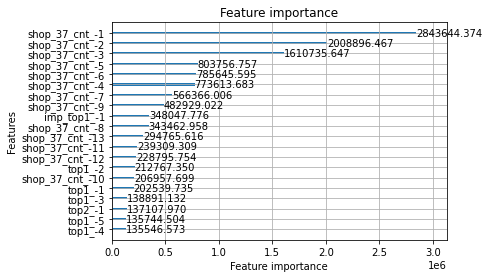

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.887714	valid_1's auc: 0.856067
[100]	training's auc: 0.897695	valid_1's auc: 0.85751
[150]	training's auc: 0.907227	valid_1's auc: 0.858174
[200]	training's auc: 0.916642	valid_1's auc: 0.858609
[250]	training's auc: 0.925701	valid_1's auc: 0.859039
[300]	training's auc: 0.934743	valid_1's auc: 0.85924
[350]	training's auc: 0.943266	valid_1's auc: 0.859363
[400]	training's auc: 0.951043	valid_1's auc: 0.859556
[450]	training's auc: 0.95768	valid_1's auc: 0.85959
[500]	training's auc: 0.963464	valid_1's auc: 0.859627
[550]	training's auc: 0.968731	valid_1's auc: 0.859663
[600]	training's auc: 0.972869	valid_1's auc: 0.859607
[650]	training's auc: 0.976627	valid_1's auc: 0.859493
Early stopping, best iteration is:
[550]	training's auc: 0.968731	valid_1's auc: 0.859663


<Figure size 864x432 with 0 Axes>

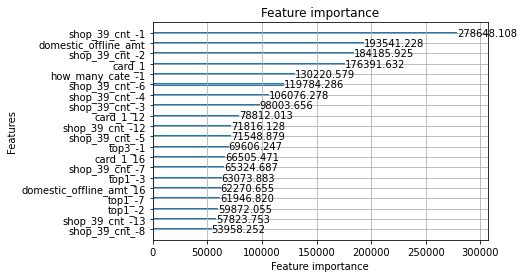

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.911882	valid_1's auc: 0.904035
[100]	training's auc: 0.914886	valid_1's auc: 0.905026
[150]	training's auc: 0.917801	valid_1's auc: 0.905576
[200]	training's auc: 0.921013	valid_1's auc: 0.906093
[250]	training's auc: 0.924449	valid_1's auc: 0.906518
[300]	training's auc: 0.928131	valid_1's auc: 0.906734
[350]	training's auc: 0.931993	valid_1's auc: 0.906934
[400]	training's auc: 0.936036	valid_1's auc: 0.907014
[450]	training's auc: 0.940056	valid_1's auc: 0.907066
[500]	training's auc: 0.943848	valid_1's auc: 0.907178
[550]	training's auc: 0.947523	valid_1's auc: 0.907221
[600]	training's auc: 0.950852	valid_1's auc: 0.907245
[650]	training's auc: 0.953927	valid_1's auc: 0.907266
[700]	training's auc: 0.956798	valid_1's auc: 0.907265
[750]	training's auc: 0.959527	valid_1's auc: 0.907304
[800]	training's auc: 0.962059	valid_1's auc: 0.907289
[850]	training's auc: 0.964397	valid_1's auc: 0.90725
Early

<Figure size 864x432 with 0 Axes>

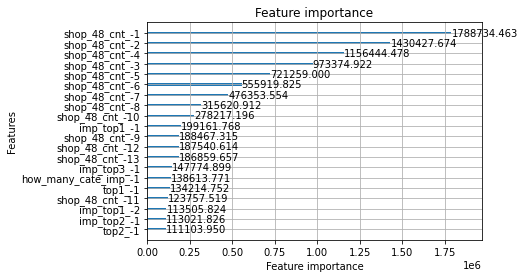

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.867282	valid_1's auc: 0.852744
[100]	training's auc: 0.871842	valid_1's auc: 0.853784
[150]	training's auc: 0.876468	valid_1's auc: 0.85448
[200]	training's auc: 0.881253	valid_1's auc: 0.855094
[250]	training's auc: 0.886266	valid_1's auc: 0.855469
[300]	training's auc: 0.891475	valid_1's auc: 0.855764
[350]	training's auc: 0.896851	valid_1's auc: 0.856031
[400]	training's auc: 0.902245	valid_1's auc: 0.856241
[450]	training's auc: 0.907484	valid_1's auc: 0.856391
[500]	training's auc: 0.912471	valid_1's auc: 0.856556
[550]	training's auc: 0.917396	valid_1's auc: 0.856641
[600]	training's auc: 0.92188	valid_1's auc: 0.856722
[650]	training's auc: 0.92624	valid_1's auc: 0.856736
[700]	training's auc: 0.930304	valid_1's auc: 0.856731
Early stopping, best iteration is:
[639]	training's auc: 0.925277	valid_1's auc: 0.856743


<Figure size 864x432 with 0 Axes>

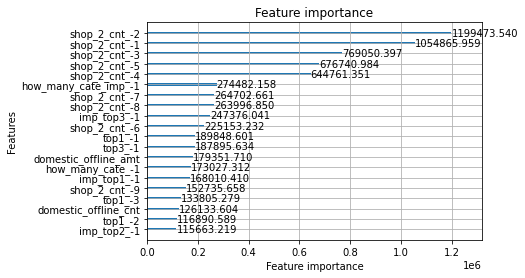

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.914193	valid_1's auc: 0.89272
[100]	training's auc: 0.92091	valid_1's auc: 0.893353
[150]	training's auc: 0.927445	valid_1's auc: 0.893758
[200]	training's auc: 0.934752	valid_1's auc: 0.894068
[250]	training's auc: 0.942267	valid_1's auc: 0.894337
[300]	training's auc: 0.949449	valid_1's auc: 0.894493
[350]	training's auc: 0.956116	valid_1's auc: 0.894607
[400]	training's auc: 0.96215	valid_1's auc: 0.894674
[450]	training's auc: 0.967547	valid_1's auc: 0.894832
[500]	training's auc: 0.972031	valid_1's auc: 0.89492
[550]	training's auc: 0.975929	valid_1's auc: 0.894895
[600]	training's auc: 0.979181	valid_1's auc: 0.894841
Early stopping, best iteration is:
[520]	training's auc: 0.973663	valid_1's auc: 0.894951


<Figure size 864x432 with 0 Axes>

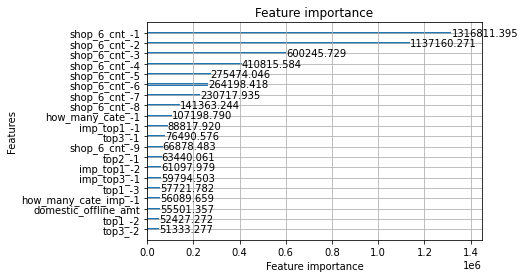

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.925515	valid_1's auc: 0.920241
[100]	training's auc: 0.928195	valid_1's auc: 0.921453
[150]	training's auc: 0.93061	valid_1's auc: 0.922134
[200]	training's auc: 0.933103	valid_1's auc: 0.922542
[250]	training's auc: 0.935805	valid_1's auc: 0.922888
[300]	training's auc: 0.938747	valid_1's auc: 0.923253
[350]	training's auc: 0.941827	valid_1's auc: 0.923493
[400]	training's auc: 0.945111	valid_1's auc: 0.923693
[450]	training's auc: 0.948377	valid_1's auc: 0.923888
[500]	training's auc: 0.951669	valid_1's auc: 0.924041
[550]	training's auc: 0.954808	valid_1's auc: 0.924152
[600]	training's auc: 0.957768	valid_1's auc: 0.924266
[650]	training's auc: 0.960668	valid_1's auc: 0.924341
[700]	training's auc: 0.963322	valid_1's auc: 0.924396
[750]	training's auc: 0.965838	valid_1's auc: 0.924451
[800]	training's auc: 0.968166	valid_1's auc: 0.924476
[850]	training's auc: 0.970262	valid_1's auc: 0.924494
[900]

<Figure size 864x432 with 0 Axes>

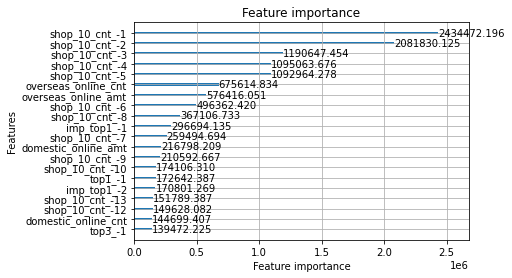

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.923454	valid_1's auc: 0.914038
[100]	training's auc: 0.926948	valid_1's auc: 0.91478
[150]	training's auc: 0.930412	valid_1's auc: 0.915158
[200]	training's auc: 0.934378	valid_1's auc: 0.915522
[250]	training's auc: 0.938769	valid_1's auc: 0.915807
[300]	training's auc: 0.943363	valid_1's auc: 0.916027
[350]	training's auc: 0.948113	valid_1's auc: 0.9162
[400]	training's auc: 0.952768	valid_1's auc: 0.916338
[450]	training's auc: 0.957282	valid_1's auc: 0.91646
[500]	training's auc: 0.961425	valid_1's auc: 0.916493
[550]	training's auc: 0.965241	valid_1's auc: 0.916512
[600]	training's auc: 0.968491	valid_1's auc: 0.916551
[650]	training's auc: 0.971515	valid_1's auc: 0.916554
[700]	training's auc: 0.974175	valid_1's auc: 0.916521
[750]	training's auc: 0.976523	valid_1's auc: 0.916485
Early stopping, best iteration is:
[665]	training's auc: 0.972329	valid_1's auc: 0.916573


<Figure size 864x432 with 0 Axes>

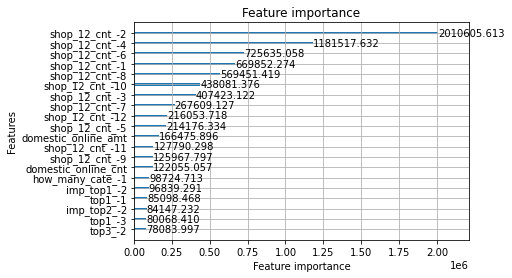

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.957389	valid_1's auc: 0.950481
[100]	training's auc: 0.960178	valid_1's auc: 0.952004
[150]	training's auc: 0.962827	valid_1's auc: 0.952971
[200]	training's auc: 0.965403	valid_1's auc: 0.953702
[250]	training's auc: 0.967788	valid_1's auc: 0.953861
[300]	training's auc: 0.97052	valid_1's auc: 0.954269
[350]	training's auc: 0.973375	valid_1's auc: 0.954591
[400]	training's auc: 0.976271	valid_1's auc: 0.954807
[450]	training's auc: 0.979093	valid_1's auc: 0.955135
[500]	training's auc: 0.981766	valid_1's auc: 0.955468
[550]	training's auc: 0.984065	valid_1's auc: 0.955685
[600]	training's auc: 0.986087	valid_1's auc: 0.955831
[650]	training's auc: 0.987881	valid_1's auc: 0.95598
[700]	training's auc: 0.989548	valid_1's auc: 0.95606
[750]	training's auc: 0.990973	valid_1's auc: 0.956105
[800]	training's auc: 0.992168	valid_1's auc: 0.956125
[850]	training's auc: 0.99324	valid_1's auc: 0.956179
[900]	tr

<Figure size 864x432 with 0 Axes>

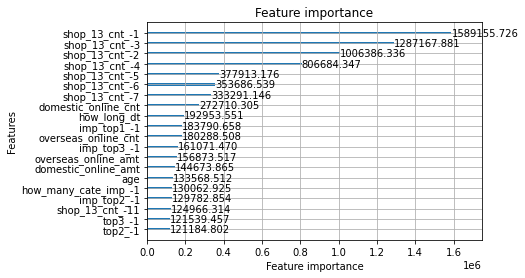

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.881335	valid_1's auc: 0.873952
[100]	training's auc: 0.884865	valid_1's auc: 0.875036
[150]	training's auc: 0.888639	valid_1's auc: 0.875949
[200]	training's auc: 0.892465	valid_1's auc: 0.876514
[250]	training's auc: 0.896482	valid_1's auc: 0.877026
[300]	training's auc: 0.900581	valid_1's auc: 0.877436
[350]	training's auc: 0.904707	valid_1's auc: 0.877705
[400]	training's auc: 0.908818	valid_1's auc: 0.877949
[450]	training's auc: 0.912948	valid_1's auc: 0.878092
[500]	training's auc: 0.916889	valid_1's auc: 0.878202
[550]	training's auc: 0.920694	valid_1's auc: 0.878307
[600]	training's auc: 0.924266	valid_1's auc: 0.878384
[650]	training's auc: 0.92762	valid_1's auc: 0.878427
[700]	training's auc: 0.930871	valid_1's auc: 0.878451
[750]	training's auc: 0.933955	valid_1's auc: 0.87847
[800]	training's auc: 0.936821	valid_1's auc: 0.878465
[850]	training's auc: 0.939545	valid_1's auc: 0.87846
Early s

<Figure size 864x432 with 0 Axes>

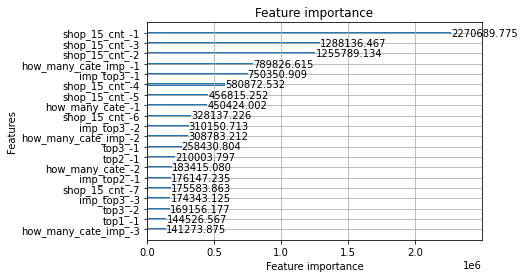

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876424	valid_1's auc: 0.851988
[100]	training's auc: 0.884549	valid_1's auc: 0.852878
[150]	training's auc: 0.89266	valid_1's auc: 0.853642
[200]	training's auc: 0.901152	valid_1's auc: 0.854144
[250]	training's auc: 0.909735	valid_1's auc: 0.854629
[300]	training's auc: 0.918259	valid_1's auc: 0.855081
[350]	training's auc: 0.926499	valid_1's auc: 0.855331
[400]	training's auc: 0.934189	valid_1's auc: 0.855536
[450]	training's auc: 0.941162	valid_1's auc: 0.85572
[500]	training's auc: 0.947639	valid_1's auc: 0.855753
[550]	training's auc: 0.953374	valid_1's auc: 0.8558
[600]	training's auc: 0.958555	valid_1's auc: 0.855747
[650]	training's auc: 0.963347	valid_1's auc: 0.855735
Early stopping, best iteration is:
[559]	training's auc: 0.954262	valid_1's auc: 0.855813


<Figure size 864x432 with 0 Axes>

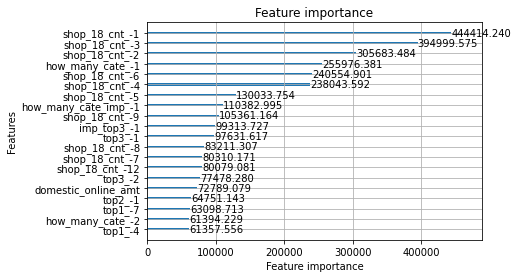

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.841547	valid_1's auc: 0.813417
[100]	training's auc: 0.850874	valid_1's auc: 0.815135
[150]	training's auc: 0.859947	valid_1's auc: 0.816388
[200]	training's auc: 0.869196	valid_1's auc: 0.817363
[250]	training's auc: 0.878543	valid_1's auc: 0.818039
[300]	training's auc: 0.887727	valid_1's auc: 0.818638
[350]	training's auc: 0.896753	valid_1's auc: 0.819049
[400]	training's auc: 0.905415	valid_1's auc: 0.819308
[450]	training's auc: 0.913502	valid_1's auc: 0.819573
[500]	training's auc: 0.920982	valid_1's auc: 0.819769
[550]	training's auc: 0.927967	valid_1's auc: 0.819833
[600]	training's auc: 0.934247	valid_1's auc: 0.819928
[650]	training's auc: 0.940074	valid_1's auc: 0.819986
[700]	training's auc: 0.945407	valid_1's auc: 0.82002
[750]	training's auc: 0.950148	valid_1's auc: 0.820021
[800]	training's auc: 0.954354	valid_1's auc: 0.819956
Early stopping, best iteration is:
[732]	training's auc: 0.9

<Figure size 864x432 with 0 Axes>

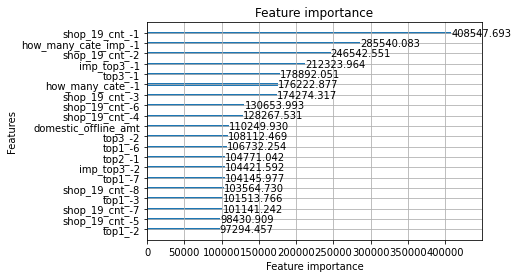

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.852522	valid_1's auc: 0.816442
[100]	training's auc: 0.863891	valid_1's auc: 0.817812
[150]	training's auc: 0.874892	valid_1's auc: 0.818814
[200]	training's auc: 0.885783	valid_1's auc: 0.819505
[250]	training's auc: 0.896707	valid_1's auc: 0.820026
[300]	training's auc: 0.907127	valid_1's auc: 0.820408
[350]	training's auc: 0.91708	valid_1's auc: 0.820897
[400]	training's auc: 0.926199	valid_1's auc: 0.821196
[450]	training's auc: 0.934061	valid_1's auc: 0.82139
[500]	training's auc: 0.941162	valid_1's auc: 0.821529
[550]	training's auc: 0.947572	valid_1's auc: 0.821594
[600]	training's auc: 0.953196	valid_1's auc: 0.821583
[650]	training's auc: 0.957962	valid_1's auc: 0.821514
Early stopping, best iteration is:
[556]	training's auc: 0.948201	valid_1's auc: 0.821595


<Figure size 864x432 with 0 Axes>

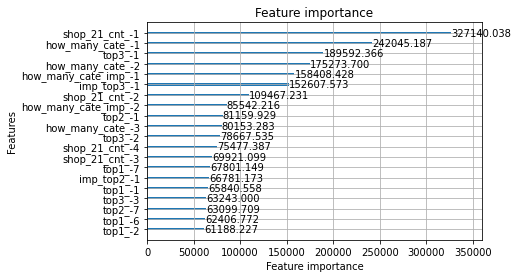

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.893213	valid_1's auc: 0.875651
[100]	training's auc: 0.900209	valid_1's auc: 0.876977
[150]	training's auc: 0.906973	valid_1's auc: 0.877612
[200]	training's auc: 0.91368	valid_1's auc: 0.878107
[250]	training's auc: 0.9211	valid_1's auc: 0.878497
[300]	training's auc: 0.928572	valid_1's auc: 0.878766
[350]	training's auc: 0.935916	valid_1's auc: 0.879054
[400]	training's auc: 0.94293	valid_1's auc: 0.879179
[450]	training's auc: 0.949409	valid_1's auc: 0.879254
[500]	training's auc: 0.955137	valid_1's auc: 0.879319
[550]	training's auc: 0.960214	valid_1's auc: 0.879315
[600]	training's auc: 0.964869	valid_1's auc: 0.879251
Early stopping, best iteration is:
[521]	training's auc: 0.957413	valid_1's auc: 0.879352


<Figure size 864x432 with 0 Axes>

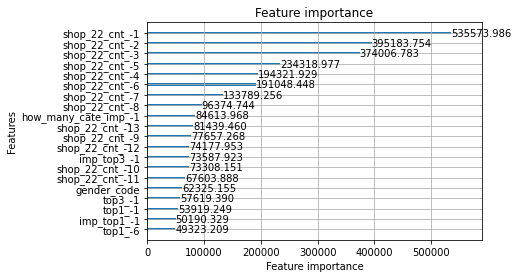

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.88097	valid_1's auc: 0.863498
[100]	training's auc: 0.887904	valid_1's auc: 0.864702
[150]	training's auc: 0.895025	valid_1's auc: 0.865497
[200]	training's auc: 0.902231	valid_1's auc: 0.866043
[250]	training's auc: 0.909354	valid_1's auc: 0.866452
[300]	training's auc: 0.916917	valid_1's auc: 0.866831
[350]	training's auc: 0.9241	valid_1's auc: 0.867065
[400]	training's auc: 0.931402	valid_1's auc: 0.867288
[450]	training's auc: 0.938429	valid_1's auc: 0.867434
[500]	training's auc: 0.944791	valid_1's auc: 0.867497
[550]	training's auc: 0.950585	valid_1's auc: 0.867535
[600]	training's auc: 0.955632	valid_1's auc: 0.867537
Early stopping, best iteration is:
[539]	training's auc: 0.949303	valid_1's auc: 0.867559


<Figure size 864x432 with 0 Axes>

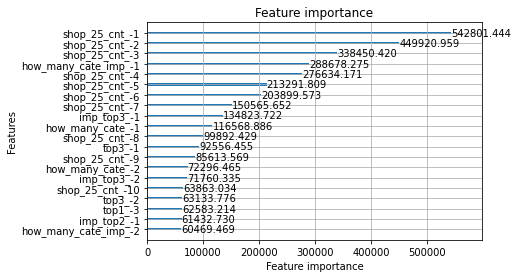

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.896724	valid_1's auc: 0.87314
[100]	training's auc: 0.904335	valid_1's auc: 0.87428
[150]	training's auc: 0.91254	valid_1's auc: 0.874658
[200]	training's auc: 0.921392	valid_1's auc: 0.874939
[250]	training's auc: 0.930168	valid_1's auc: 0.875329
[300]	training's auc: 0.939125	valid_1's auc: 0.875399
[350]	training's auc: 0.947405	valid_1's auc: 0.875577
[400]	training's auc: 0.954909	valid_1's auc: 0.875622
[450]	training's auc: 0.961547	valid_1's auc: 0.875582
[500]	training's auc: 0.966916	valid_1's auc: 0.875529
Early stopping, best iteration is:
[401]	training's auc: 0.955051	valid_1's auc: 0.875637


<Figure size 864x432 with 0 Axes>

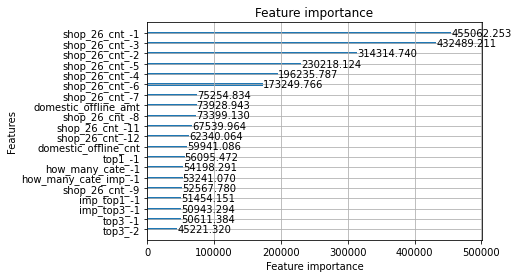

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942151	valid_1's auc: 0.938608
[100]	training's auc: 0.943642	valid_1's auc: 0.939241
[150]	training's auc: 0.945333	valid_1's auc: 0.939904
[200]	training's auc: 0.946998	valid_1's auc: 0.940336
[250]	training's auc: 0.948811	valid_1's auc: 0.940638
[300]	training's auc: 0.950761	valid_1's auc: 0.940796
[350]	training's auc: 0.952953	valid_1's auc: 0.941003
[400]	training's auc: 0.955238	valid_1's auc: 0.941196
[450]	training's auc: 0.957607	valid_1's auc: 0.941338
[500]	training's auc: 0.959978	valid_1's auc: 0.941413
[550]	training's auc: 0.962174	valid_1's auc: 0.941479
[600]	training's auc: 0.964317	valid_1's auc: 0.941518
[650]	training's auc: 0.966327	valid_1's auc: 0.941564
[700]	training's auc: 0.968238	valid_1's auc: 0.941609
[750]	training's auc: 0.970095	valid_1's auc: 0.941632
[800]	training's auc: 0.971771	valid_1's auc: 0.941644
[850]	training's auc: 0.973427	valid_1's auc: 0.941647
[900

<Figure size 864x432 with 0 Axes>

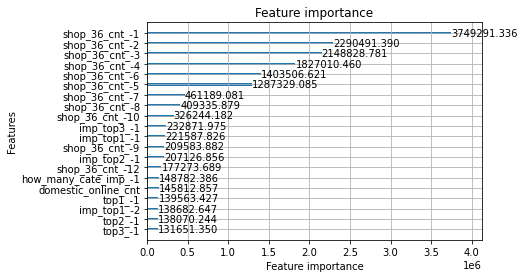

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.882112	valid_1's auc: 0.876039
[100]	training's auc: 0.884988	valid_1's auc: 0.876943
[150]	training's auc: 0.887885	valid_1's auc: 0.877455
[200]	training's auc: 0.891134	valid_1's auc: 0.878165
[250]	training's auc: 0.894622	valid_1's auc: 0.878691
[300]	training's auc: 0.898171	valid_1's auc: 0.87902
[350]	training's auc: 0.901757	valid_1's auc: 0.879302
[400]	training's auc: 0.905393	valid_1's auc: 0.879494
[450]	training's auc: 0.909015	valid_1's auc: 0.879632
[500]	training's auc: 0.912512	valid_1's auc: 0.879779
[550]	training's auc: 0.915929	valid_1's auc: 0.879864
[600]	training's auc: 0.919313	valid_1's auc: 0.879957
[650]	training's auc: 0.922367	valid_1's auc: 0.880055
[700]	training's auc: 0.925334	valid_1's auc: 0.880097
[750]	training's auc: 0.928203	valid_1's auc: 0.880124
[800]	training's auc: 0.931039	valid_1's auc: 0.88016
[850]	training's auc: 0.933689	valid_1's auc: 0.880179
[900]	

<Figure size 864x432 with 0 Axes>

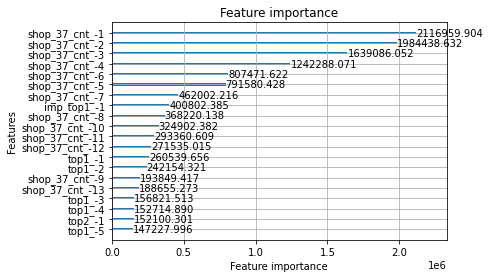

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.887136	valid_1's auc: 0.856699
[100]	training's auc: 0.896771	valid_1's auc: 0.858068
[150]	training's auc: 0.90624	valid_1's auc: 0.858988
[200]	training's auc: 0.915514	valid_1's auc: 0.859618
[250]	training's auc: 0.924693	valid_1's auc: 0.860037
[300]	training's auc: 0.933498	valid_1's auc: 0.860315
[350]	training's auc: 0.942045	valid_1's auc: 0.860523
[400]	training's auc: 0.949891	valid_1's auc: 0.860684
[450]	training's auc: 0.95654	valid_1's auc: 0.860721
[500]	training's auc: 0.962474	valid_1's auc: 0.860742
[550]	training's auc: 0.967554	valid_1's auc: 0.860728
[600]	training's auc: 0.972179	valid_1's auc: 0.860729
Early stopping, best iteration is:
[512]	training's auc: 0.96381	valid_1's auc: 0.860767


<Figure size 864x432 with 0 Axes>

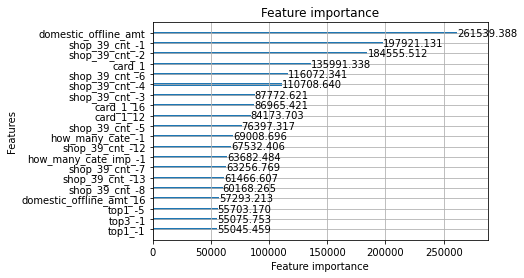

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.91191	valid_1's auc: 0.905375
[100]	training's auc: 0.914903	valid_1's auc: 0.906242
[150]	training's auc: 0.917831	valid_1's auc: 0.906737
[200]	training's auc: 0.920994	valid_1's auc: 0.907112
[250]	training's auc: 0.924359	valid_1's auc: 0.907361
[300]	training's auc: 0.928065	valid_1's auc: 0.90759
[350]	training's auc: 0.931954	valid_1's auc: 0.90772
[400]	training's auc: 0.935941	valid_1's auc: 0.907828
[450]	training's auc: 0.939913	valid_1's auc: 0.907871
[500]	training's auc: 0.943843	valid_1's auc: 0.907931
[550]	training's auc: 0.947325	valid_1's auc: 0.907977
[600]	training's auc: 0.950612	valid_1's auc: 0.907999
[650]	training's auc: 0.953785	valid_1's auc: 0.908033
[700]	training's auc: 0.956828	valid_1's auc: 0.908046
[750]	training's auc: 0.959489	valid_1's auc: 0.90803
Early stopping, best iteration is:
[687]	training's auc: 0.95598	valid_1's auc: 0.908049


<Figure size 864x432 with 0 Axes>

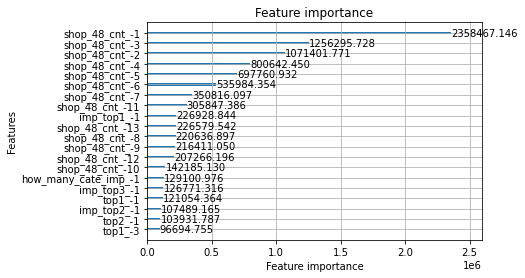

Training fold 4
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.866986	valid_1's auc: 0.854993
[100]	training's auc: 0.871577	valid_1's auc: 0.855937
[150]	training's auc: 0.876137	valid_1's auc: 0.856465
[200]	training's auc: 0.88092	valid_1's auc: 0.856961
[250]	training's auc: 0.885878	valid_1's auc: 0.857302
[300]	training's auc: 0.891154	valid_1's auc: 0.857547
[350]	training's auc: 0.896493	valid_1's auc: 0.857774
[400]	training's auc: 0.901854	valid_1's auc: 0.857949
[450]	training's auc: 0.907098	valid_1's auc: 0.858074
[500]	training's auc: 0.912189	valid_1's auc: 0.858191
[550]	training's auc: 0.917038	valid_1's auc: 0.858249
[600]	training's auc: 0.921612	valid_1's auc: 0.858283
[650]	training's auc: 0.925879	valid_1's auc: 0.85831
[700]	training's auc: 0.930122	valid_1's auc: 0.858312
[750]	training's auc: 0.934075	valid_1's auc: 0.858327
[800]	training's auc: 0.93779	valid_1's auc: 0.858308
[850]	training's auc: 0.941262	valid_1's auc: 

<Figure size 864x432 with 0 Axes>

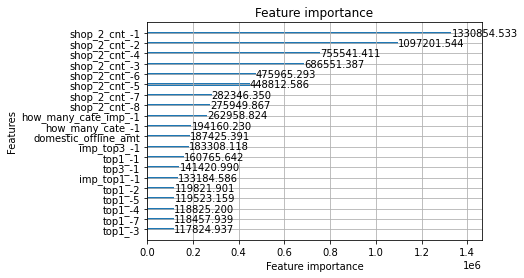

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.914562	valid_1's auc: 0.890884
[100]	training's auc: 0.921122	valid_1's auc: 0.891709
[150]	training's auc: 0.927655	valid_1's auc: 0.892175
[200]	training's auc: 0.934727	valid_1's auc: 0.892449
[250]	training's auc: 0.942073	valid_1's auc: 0.892699
[300]	training's auc: 0.949367	valid_1's auc: 0.892883
[350]	training's auc: 0.956109	valid_1's auc: 0.893058
[400]	training's auc: 0.962261	valid_1's auc: 0.893174
[450]	training's auc: 0.967744	valid_1's auc: 0.893285
[500]	training's auc: 0.972281	valid_1's auc: 0.893331
[550]	training's auc: 0.976058	valid_1's auc: 0.893283
[600]	training's auc: 0.979315	valid_1's auc: 0.893133
Early stopping, best iteration is:
[502]	training's auc: 0.972441	valid_1's auc: 0.893336


<Figure size 864x432 with 0 Axes>

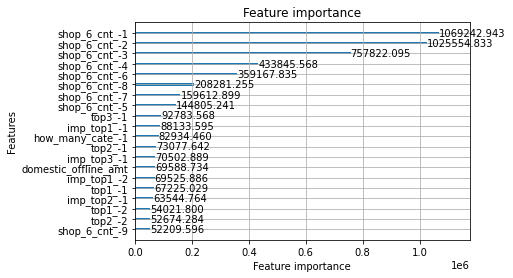

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.925927	valid_1's auc: 0.920529
[100]	training's auc: 0.928413	valid_1's auc: 0.921425
[150]	training's auc: 0.930635	valid_1's auc: 0.921863
[200]	training's auc: 0.93304	valid_1's auc: 0.922234
[250]	training's auc: 0.935808	valid_1's auc: 0.922665
[300]	training's auc: 0.938798	valid_1's auc: 0.92313
[350]	training's auc: 0.941953	valid_1's auc: 0.923428
[400]	training's auc: 0.945261	valid_1's auc: 0.923651
[450]	training's auc: 0.948551	valid_1's auc: 0.923776
[500]	training's auc: 0.951775	valid_1's auc: 0.923936
[550]	training's auc: 0.954864	valid_1's auc: 0.924074
[600]	training's auc: 0.95787	valid_1's auc: 0.924177
[650]	training's auc: 0.960622	valid_1's auc: 0.924247
[700]	training's auc: 0.963322	valid_1's auc: 0.924339
[750]	training's auc: 0.965736	valid_1's auc: 0.924409
[800]	training's auc: 0.968165	valid_1's auc: 0.92447
[850]	training's auc: 0.970322	valid_1's auc: 0.924487
[900]	tr

<Figure size 864x432 with 0 Axes>

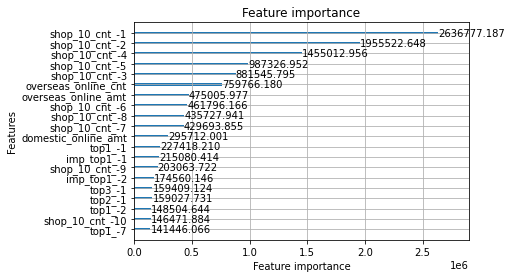

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.922779	valid_1's auc: 0.913235
[100]	training's auc: 0.92657	valid_1's auc: 0.914342
[150]	training's auc: 0.930272	valid_1's auc: 0.914806
[200]	training's auc: 0.934302	valid_1's auc: 0.915106
[250]	training's auc: 0.938657	valid_1's auc: 0.915335
[300]	training's auc: 0.943289	valid_1's auc: 0.915493
[350]	training's auc: 0.948061	valid_1's auc: 0.915637
[400]	training's auc: 0.95272	valid_1's auc: 0.915776
[450]	training's auc: 0.957134	valid_1's auc: 0.915876
[500]	training's auc: 0.961318	valid_1's auc: 0.915956
[550]	training's auc: 0.965017	valid_1's auc: 0.916029
[600]	training's auc: 0.968288	valid_1's auc: 0.91609
[650]	training's auc: 0.971361	valid_1's auc: 0.916131
[700]	training's auc: 0.973984	valid_1's auc: 0.916166
[750]	training's auc: 0.976345	valid_1's auc: 0.916144
[800]	training's auc: 0.978538	valid_1's auc: 0.916149
Early stopping, best iteration is:
[711]	training's auc: 0.974

<Figure size 864x432 with 0 Axes>

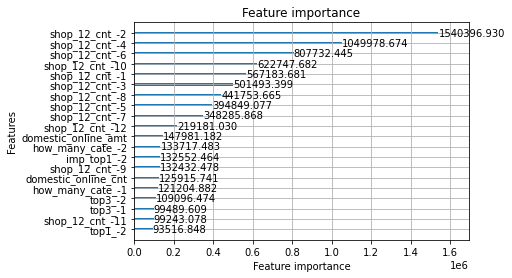

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.957921	valid_1's auc: 0.953518
[100]	training's auc: 0.960253	valid_1's auc: 0.954381
[150]	training's auc: 0.962426	valid_1's auc: 0.954912
[200]	training's auc: 0.964693	valid_1's auc: 0.955351
[250]	training's auc: 0.967376	valid_1's auc: 0.955857
[300]	training's auc: 0.970061	valid_1's auc: 0.956086
[350]	training's auc: 0.972972	valid_1's auc: 0.956434
[400]	training's auc: 0.97592	valid_1's auc: 0.956804
[450]	training's auc: 0.978669	valid_1's auc: 0.957011
[500]	training's auc: 0.981327	valid_1's auc: 0.957192
[550]	training's auc: 0.983753	valid_1's auc: 0.957437
[600]	training's auc: 0.985874	valid_1's auc: 0.95761
[650]	training's auc: 0.987742	valid_1's auc: 0.957728
[700]	training's auc: 0.989313	valid_1's auc: 0.957756
[750]	training's auc: 0.990768	valid_1's auc: 0.95782
[800]	training's auc: 0.992002	valid_1's auc: 0.95788
[850]	training's auc: 0.993089	valid_1's auc: 0.957889
[900]	tr

<Figure size 864x432 with 0 Axes>

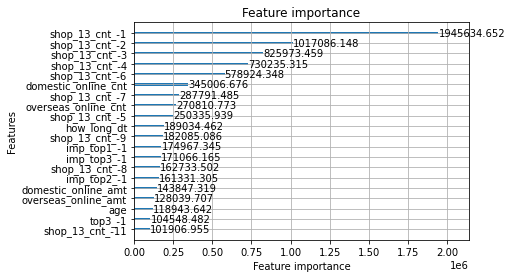

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.881171	valid_1's auc: 0.873051
[100]	training's auc: 0.884892	valid_1's auc: 0.874224
[150]	training's auc: 0.888614	valid_1's auc: 0.875199
[200]	training's auc: 0.892325	valid_1's auc: 0.875735
[250]	training's auc: 0.896391	valid_1's auc: 0.87642
[300]	training's auc: 0.900433	valid_1's auc: 0.87692
[350]	training's auc: 0.904612	valid_1's auc: 0.877293
[400]	training's auc: 0.908758	valid_1's auc: 0.877587
[450]	training's auc: 0.912848	valid_1's auc: 0.877812
[500]	training's auc: 0.916692	valid_1's auc: 0.877978
[550]	training's auc: 0.920434	valid_1's auc: 0.878123
[600]	training's auc: 0.923971	valid_1's auc: 0.878241
[650]	training's auc: 0.927419	valid_1's auc: 0.878307
[700]	training's auc: 0.930655	valid_1's auc: 0.878364
[750]	training's auc: 0.933822	valid_1's auc: 0.878396
[800]	training's auc: 0.936768	valid_1's auc: 0.878417
[850]	training's auc: 0.939614	valid_1's auc: 0.878434
[900]	

<Figure size 864x432 with 0 Axes>

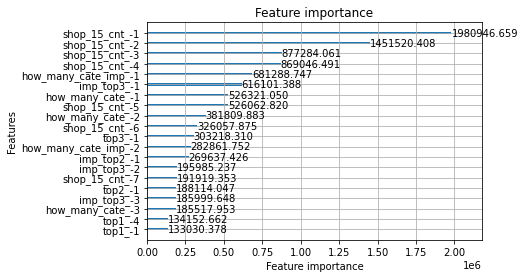

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.876769	valid_1's auc: 0.850811
[100]	training's auc: 0.884906	valid_1's auc: 0.852077
[150]	training's auc: 0.892877	valid_1's auc: 0.852539
[200]	training's auc: 0.901072	valid_1's auc: 0.853091
[250]	training's auc: 0.909606	valid_1's auc: 0.8534
[300]	training's auc: 0.918092	valid_1's auc: 0.853771
[350]	training's auc: 0.926436	valid_1's auc: 0.853915
[400]	training's auc: 0.934435	valid_1's auc: 0.854079
[450]	training's auc: 0.941648	valid_1's auc: 0.854295
[500]	training's auc: 0.948113	valid_1's auc: 0.85428
[550]	training's auc: 0.953887	valid_1's auc: 0.854304
[600]	training's auc: 0.958868	valid_1's auc: 0.854278
Early stopping, best iteration is:
[543]	training's auc: 0.953074	valid_1's auc: 0.854321


<Figure size 864x432 with 0 Axes>

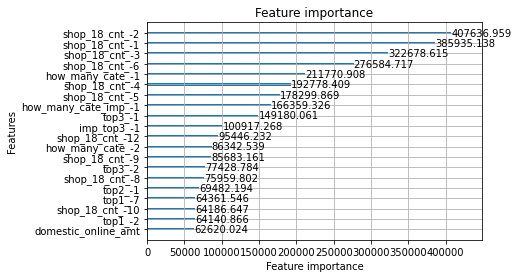

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.84196	valid_1's auc: 0.811245
[100]	training's auc: 0.851728	valid_1's auc: 0.813183
[150]	training's auc: 0.860963	valid_1's auc: 0.814306
[200]	training's auc: 0.870296	valid_1's auc: 0.815346
[250]	training's auc: 0.879484	valid_1's auc: 0.816054
[300]	training's auc: 0.888658	valid_1's auc: 0.81669
[350]	training's auc: 0.89746	valid_1's auc: 0.817106
[400]	training's auc: 0.906161	valid_1's auc: 0.817434
[450]	training's auc: 0.914148	valid_1's auc: 0.817685
[500]	training's auc: 0.921816	valid_1's auc: 0.817908
[550]	training's auc: 0.928837	valid_1's auc: 0.818042
[600]	training's auc: 0.935092	valid_1's auc: 0.818083
[650]	training's auc: 0.94065	valid_1's auc: 0.818122
[700]	training's auc: 0.945964	valid_1's auc: 0.818175
[750]	training's auc: 0.950769	valid_1's auc: 0.818189
[800]	training's auc: 0.955002	valid_1's auc: 0.818165
Early stopping, best iteration is:
[723]	training's auc: 0.9482

<Figure size 864x432 with 0 Axes>

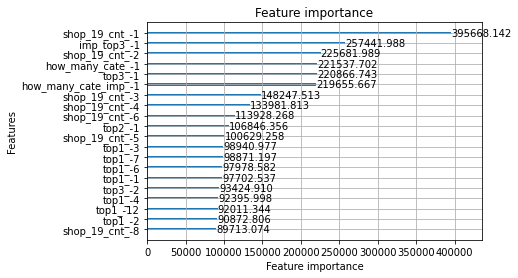

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.851656	valid_1's auc: 0.81738
[100]	training's auc: 0.863184	valid_1's auc: 0.818915
[150]	training's auc: 0.873993	valid_1's auc: 0.820042
[200]	training's auc: 0.884584	valid_1's auc: 0.820986
[250]	training's auc: 0.895226	valid_1's auc: 0.821765
[300]	training's auc: 0.905862	valid_1's auc: 0.822289
[350]	training's auc: 0.915892	valid_1's auc: 0.822706
[400]	training's auc: 0.924872	valid_1's auc: 0.823151
[450]	training's auc: 0.932672	valid_1's auc: 0.823391
[500]	training's auc: 0.939881	valid_1's auc: 0.823536
[550]	training's auc: 0.946213	valid_1's auc: 0.823603
[600]	training's auc: 0.95174	valid_1's auc: 0.823627
[650]	training's auc: 0.956673	valid_1's auc: 0.8236
Early stopping, best iteration is:
[596]	training's auc: 0.951321	valid_1's auc: 0.823643


<Figure size 864x432 with 0 Axes>

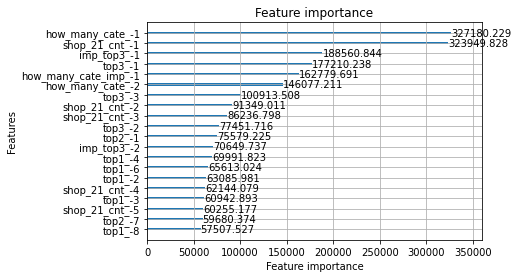

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.893239	valid_1's auc: 0.878979
[100]	training's auc: 0.899762	valid_1's auc: 0.879846
[150]	training's auc: 0.90637	valid_1's auc: 0.880168
[200]	training's auc: 0.913639	valid_1's auc: 0.880471
[250]	training's auc: 0.921163	valid_1's auc: 0.88083
[300]	training's auc: 0.928513	valid_1's auc: 0.881038
[350]	training's auc: 0.935741	valid_1's auc: 0.881368
[400]	training's auc: 0.942822	valid_1's auc: 0.881584
[450]	training's auc: 0.949217	valid_1's auc: 0.88167
[500]	training's auc: 0.955055	valid_1's auc: 0.881744
[550]	training's auc: 0.960194	valid_1's auc: 0.88177
[600]	training's auc: 0.964754	valid_1's auc: 0.881762
Early stopping, best iteration is:
[528]	training's auc: 0.957996	valid_1's auc: 0.881781


<Figure size 864x432 with 0 Axes>

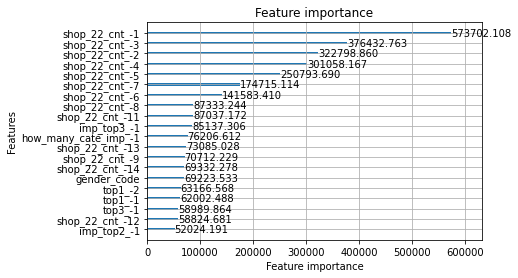

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.882359	valid_1's auc: 0.86178
[100]	training's auc: 0.888918	valid_1's auc: 0.862881
[150]	training's auc: 0.895782	valid_1's auc: 0.863469
[200]	training's auc: 0.903079	valid_1's auc: 0.864
[250]	training's auc: 0.910305	valid_1's auc: 0.864475
[300]	training's auc: 0.917721	valid_1's auc: 0.864837
[350]	training's auc: 0.924997	valid_1's auc: 0.865121
[400]	training's auc: 0.932057	valid_1's auc: 0.865306
[450]	training's auc: 0.938957	valid_1's auc: 0.865451
[500]	training's auc: 0.945069	valid_1's auc: 0.865543
[550]	training's auc: 0.950791	valid_1's auc: 0.865638
[600]	training's auc: 0.956007	valid_1's auc: 0.865672
[650]	training's auc: 0.96064	valid_1's auc: 0.865705
[700]	training's auc: 0.964765	valid_1's auc: 0.865695
[750]	training's auc: 0.968354	valid_1's auc: 0.865613
Early stopping, best iteration is:
[695]	training's auc: 0.964409	valid_1's auc: 0.865709


<Figure size 864x432 with 0 Axes>

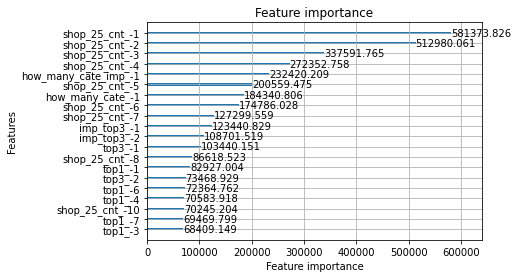

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.896132	valid_1's auc: 0.872481
[100]	training's auc: 0.904082	valid_1's auc: 0.873626
[150]	training's auc: 0.912558	valid_1's auc: 0.874219
[200]	training's auc: 0.921305	valid_1's auc: 0.874575
[250]	training's auc: 0.930357	valid_1's auc: 0.874965
[300]	training's auc: 0.939083	valid_1's auc: 0.875404
[350]	training's auc: 0.947553	valid_1's auc: 0.875725
[400]	training's auc: 0.954959	valid_1's auc: 0.87599
[450]	training's auc: 0.961502	valid_1's auc: 0.876156
[500]	training's auc: 0.967038	valid_1's auc: 0.876219
[550]	training's auc: 0.971767	valid_1's auc: 0.876208
[600]	training's auc: 0.975788	valid_1's auc: 0.876221
[650]	training's auc: 0.979146	valid_1's auc: 0.876196
[700]	training's auc: 0.982139	valid_1's auc: 0.8762
Early stopping, best iteration is:
[630]	training's auc: 0.977911	valid_1's auc: 0.876247


<Figure size 864x432 with 0 Axes>

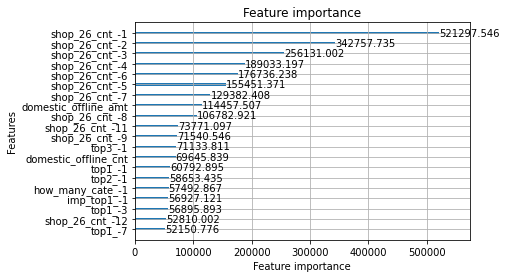

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.942298	valid_1's auc: 0.93961
[100]	training's auc: 0.944032	valid_1's auc: 0.940393
[150]	training's auc: 0.945284	valid_1's auc: 0.940557
[200]	training's auc: 0.946869	valid_1's auc: 0.940932
[250]	training's auc: 0.948558	valid_1's auc: 0.941087
[300]	training's auc: 0.950493	valid_1's auc: 0.941308
[350]	training's auc: 0.952652	valid_1's auc: 0.941544
[400]	training's auc: 0.954987	valid_1's auc: 0.94171
[450]	training's auc: 0.95739	valid_1's auc: 0.941871
[500]	training's auc: 0.959725	valid_1's auc: 0.941989
[550]	training's auc: 0.961972	valid_1's auc: 0.942073
[600]	training's auc: 0.964088	valid_1's auc: 0.94212
[650]	training's auc: 0.966117	valid_1's auc: 0.942158
[700]	training's auc: 0.968021	valid_1's auc: 0.94219
[750]	training's auc: 0.969873	valid_1's auc: 0.942201
[800]	training's auc: 0.971607	valid_1's auc: 0.942205
[850]	training's auc: 0.97322	valid_1's auc: 0.942212
[900]	trai

<Figure size 864x432 with 0 Axes>

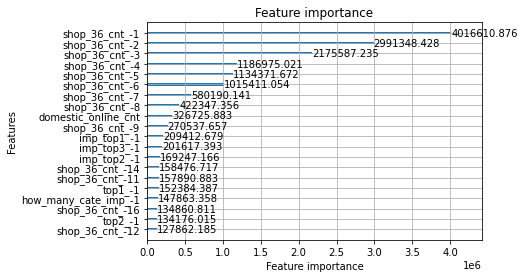

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.88264	valid_1's auc: 0.87515
[100]	training's auc: 0.88565	valid_1's auc: 0.876161
[150]	training's auc: 0.888759	valid_1's auc: 0.877086
[200]	training's auc: 0.891907	valid_1's auc: 0.877579
[250]	training's auc: 0.895185	valid_1's auc: 0.877864
[300]	training's auc: 0.898694	valid_1's auc: 0.878101
[350]	training's auc: 0.902313	valid_1's auc: 0.878373
[400]	training's auc: 0.90592	valid_1's auc: 0.878576
[450]	training's auc: 0.909535	valid_1's auc: 0.878704
[500]	training's auc: 0.913109	valid_1's auc: 0.878847
[550]	training's auc: 0.916552	valid_1's auc: 0.878951
[600]	training's auc: 0.919946	valid_1's auc: 0.87906
[650]	training's auc: 0.923113	valid_1's auc: 0.879141
[700]	training's auc: 0.926203	valid_1's auc: 0.879191
[750]	training's auc: 0.929054	valid_1's auc: 0.879228
[800]	training's auc: 0.931873	valid_1's auc: 0.879243
[850]	training's auc: 0.934512	valid_1's auc: 0.879261
[900]	tra

<Figure size 864x432 with 0 Axes>

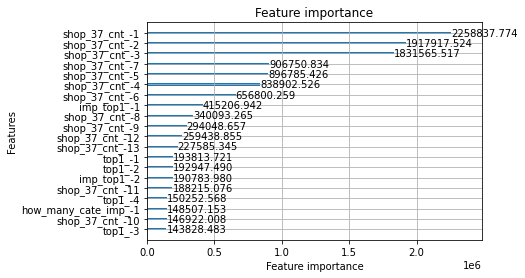

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.886333	valid_1's auc: 0.859754
[100]	training's auc: 0.896403	valid_1's auc: 0.860402
[150]	training's auc: 0.90609	valid_1's auc: 0.861038
[200]	training's auc: 0.915493	valid_1's auc: 0.861465
[250]	training's auc: 0.924924	valid_1's auc: 0.861721
[300]	training's auc: 0.933825	valid_1's auc: 0.861933
[350]	training's auc: 0.942323	valid_1's auc: 0.861985
[400]	training's auc: 0.950296	valid_1's auc: 0.86194
[450]	training's auc: 0.957225	valid_1's auc: 0.861967
Early stopping, best iteration is:
[370]	training's auc: 0.945629	valid_1's auc: 0.862001


<Figure size 864x432 with 0 Axes>

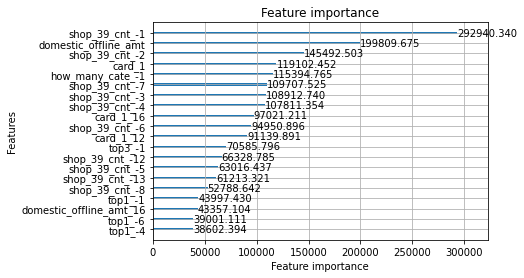

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.912254	valid_1's auc: 0.904611
[100]	training's auc: 0.915091	valid_1's auc: 0.905291
[150]	training's auc: 0.917876	valid_1's auc: 0.905647
[200]	training's auc: 0.921063	valid_1's auc: 0.906007
[250]	training's auc: 0.924551	valid_1's auc: 0.906275
[300]	training's auc: 0.928223	valid_1's auc: 0.90648
[350]	training's auc: 0.932058	valid_1's auc: 0.906657
[400]	training's auc: 0.936137	valid_1's auc: 0.906757
[450]	training's auc: 0.940111	valid_1's auc: 0.906905
[500]	training's auc: 0.943982	valid_1's auc: 0.906979
[550]	training's auc: 0.947629	valid_1's auc: 0.907026
[600]	training's auc: 0.951004	valid_1's auc: 0.907084
[650]	training's auc: 0.954185	valid_1's auc: 0.907108
[700]	training's auc: 0.957254	valid_1's auc: 0.907126
[750]	training's auc: 0.960041	valid_1's auc: 0.907129
[800]	training's auc: 0.962628	valid_1's auc: 0.907115
Early stopping, best iteration is:
[736]	training's auc: 0.9

<Figure size 864x432 with 0 Axes>

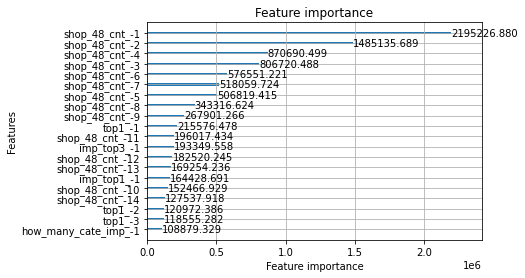

In [17]:
results = {a_cate: [] for a_cate in cnt_handler.ylabels}
train_results = {a_cate: [] for a_cate in cnt_handler.ylabels}

for fold, (trn_ind, val_ind) in enumerate(idx_results):
    print(f'Training fold {fold + 1}')
    for ylabel in cnt_handler.ylabels:
        col_name = ylabel
        # test

        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(cnt_test))
        results[ylabel].append(result)

In [18]:
cnt_results = [results, train_results, idx_results]
loader.save_data(cnt_results, '2021_12_20_cnt_train_results.joblib',
                 'fix idx error problems')
